# Replace star sampling with sampling ranges of L M and T

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi, array
import swarms
import pread as pds
from random import randint, seed, uniform
%matplotlib inline
try:
    plt.style.use('paper')
except:
    pass
from constants import MMOON, MJUP, RJUP, AU, REARTH, MEARTH, PC, MSUN, LSUN, YEAR, MICRON, STAR_TYPES

In [2]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 20 # Mearth (just over Nep. Lowest val in Baraffe)
    Mmax = 5*318 # Mearth (5 MJup. Highest in Baraffe)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = 10#star.d/PC*IWA# AU
        amax = 200#star.d/PC*OWA # AU
        a = loguniform(amin, amax)
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a*AU, Q=Q, Z='002', age=age)
    
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

def cdf(x):
    """create a lin-log cdf function using the points,
        (20, 0.0)
        (135, 0.5)
        (620, 0.9)
    from Bowler & al. 2014."""
    A = -0.785
    B = 0.603
    if isinstance(x, float) or isinstance(x, int):
        return A + B*np.log10(x)
    else:
        f = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] < 20:
                f[i] = 0
            else:
                f[i] = A + B*np.log10(x[i])
                if f[i] > 1.0:
                    f[i] = 1.0
        return f
    
def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  
    
def age_sampler2():
    y = uniform(0, 1)
    return inverse_cdf(y)*1e6 * YEAR

def age_sampler():
    return loguniform(1.1e7, 1e8) * YEAR

def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

# Sample

In [3]:
IWA = 0.2 # arcseconds
OWA = 10
MWA = (IWA + OWA)/2
lamb = 1.65 * MICRON

M0 = 1*MEARTH
aopt = 200 # AU
dopt = aopt/MWA * PC
print('Optimal Distance = {0:.0f} pc'.format(dopt/PC))

Optimal Distance = 39 pc


In [4]:
def sample(M0, dist, diststd, age, lamb):
    star = swarms.Star(M=0.5*MSUN, L=0.035*LSUN, T=3600, d=random.normal(loc=dist, scale=diststd)) # M1 star Kaltenegger & Traub
    if star.Imag < 0 or star.Imag > 12:
        print(star.Imag)
        return sample(M0, dist, diststd, age, lamb) # do it again
    
    planet = draw_planet(star, age, IWA=0.2, OWA=10)
    if planet is None:
        return sample(M0, dist, diststd, age, lamb) # do it again
    
    Dc = loguniform(1e4, 1e6) # m
    rho = loguniform(1000,3000) # kg/m^3
    eta = uniform(0.2, 0.4) # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = 0.32 # Lambert sphere at max elongation
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, M0=M0, Dmax=Dmax, Dt=Dt, eta=eta, Q=Q, g=g, rho=rho, 
                             fQ=fQ, Nstr=Nstr, Dmin_min=lamb, age=age)
    CRscatSwarm = swarm.computeCRscat()
    CRscatPlanet = planet.computeCRscat(g)
    CRthermalPlanet = planet.computeCRthermal(lamb)
    if np.isnan(CRthermalPlanet):
        CRthermalPlanet = 0
    return CRscatSwarm, CRscatPlanet+CRthermalPlanet, planet.a/AU, star.d/PC, planet.M, star.Imag

In [5]:
Nsamples = 300

dist = 35 * PC
diststd = 10 * PC
age = 2.5e7*YEAR

In [6]:
%%time
seed(0)
M1 = 0.1*MEARTH
CRscatSwarm1, CRPlanet1, a1, d1, Mplt1, Imag1 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm1[i], CRPlanet1[i], a1[i], d1[i], Mplt1[i], Imag1[i] = sample(M1, dist, diststd, age, lamb)

CPU times: user 11.8 s, sys: 852 ms, total: 12.7 s
Wall time: 12.7 s


In [7]:
%%time
seed(0)
M2 = 0.001*MEARTH
CRscatSwarm2, CRPlanet2, a2, d2, Mplt2, Imag2 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm2[i], CRPlanet2[i], a2[i], d2[i], Mplt2[i], Imag2[i] = sample(M2, dist, diststd, age, lamb)

CPU times: user 12.7 s, sys: 931 ms, total: 13.7 s
Wall time: 13.7 s


In [8]:
%%time
seed(0)
M4 = 1.e-5*MEARTH
CRscatSwarm4, CRPlanet4, a4, d4, Mplt4, Imag4 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm4[i], CRPlanet4[i], a4[i], d4[i], Mplt4[i], Imag4[i] = sample(M4, dist, diststd, age, lamb)

CPU times: user 11.9 s, sys: 856 ms, total: 12.7 s
Wall time: 12.7 s


In [9]:
def plot(ax, a, logCRscatSwarm, logCRPlanet, Mplt, Imag):
    Mcut = 2*Mplt/MEARTH
    ax.scatter(a, logCRPlanet, c='b', s=Mcut, alpha=0.3)
    sc = ax.scatter(a, logCRscatSwarm, c='g', s=Mcut, alpha=0.3)
    ax.axhline(-10, color='k', linestyle='--')
    
    ax.set_xlim([10,200])
    ax.set_ylim([-12, -4])
    ax.set_xlabel('Semimajor Axis (AU)', labelpad=15)
    ax.set_xscale('log')
    mn, mx = ax.get_xlim()
    ax.fill_between(np.linspace(mn, mx, 10), -6, -5, facecolor='m', alpha=0.3)
    ax.fill_between(np.linspace(mn, mx, 10), -9, -8, facecolor='m', alpha=0.3)
    return sc

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


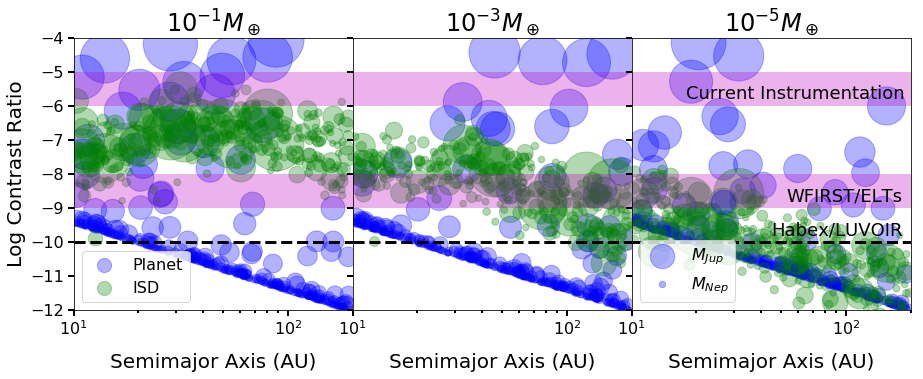

In [10]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
plt.subplots_adjust(wspace=0., hspace=0.04)

sc = plot(axs[0], a1, np.log10(CRscatSwarm1), np.log10(CRPlanet1), Mplt1, Imag1)
sc = plot(axs[1], a2, np.log10(CRscatSwarm2), np.log10(CRPlanet2), Mplt2, Imag2)
sc = plot(axs[2], a4, np.log10(CRscatSwarm4), np.log10(CRPlanet4), Mplt4, Imag4)

axs[0].set_ylabel('Log Contrast Ratio')
    
s=0.9
axs[2].text(18, -5.8, "Current Instrumentation", color='k', fontsize=18)
axs[2].text(53, -8.8, "WFIRST/ELTs", color='k', fontsize=18)
axs[2].text(45, -9.8, "Habex/LUVOIR", color='k', fontsize=18)


Mcut1 = 2*Mplt1/MEARTH
Jupmask = np.abs(Mplt1/MEARTH - 318) < 30
Nepmask = np.abs(Mplt1/MEARTH - 20) < 1
sc1 = axs[2].scatter(a1[Jupmask][0], np.log10(CRPlanet1)[Jupmask][0], c='b', s=Mcut1[Jupmask][0], alpha=0.3, label=r"$M_{Jup}$")
sc1 = axs[2].scatter(a1[Nepmask][0], np.log10(CRPlanet1)[Nepmask][0], c='b', s=Mcut1[Nepmask][0], alpha=0.3, label=r"$M_{Nep}$")
axs[2].legend(loc='lower left')
sc1 = axs[0].scatter(a1[0], np.log10(CRPlanet1)[0], c='b', s=200, alpha=0.3, label=r"Planet")
sc1 = axs[0].scatter(a1[0], np.log10(CRscatSwarm1)[0], c='g', s=200, alpha=0.3, label=r"ISD")
axs[0].legend(loc='lower left')
axs[0].set_title(r'$10^{-1} M_\oplus$')
axs[1].set_title(r'$10^{-3} M_\oplus$')
axs[2].set_title(r'$10^{-5} M_\oplus$')
fig.savefig('betapicprojections.pdf', bbox_inches='tight')